# Introduction

In this Notebook, I'll demonstrate how to dramatically increase BERT's training time by creating batches of samples with different sequence lengths. 

I learned this technique from Michaël Benesty in his excellent blog post [here](https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e), and used key pieces of his implementation ([here](https://gist.github.com/pommedeterresautee/1a334b665710bec9bb65965f662c94c8)) in this Notebook. 

> Michaël's code is designed to make use of the new `Trainer` class in the `transformers` library, and makes use of many helper classes from PyTorch and transformers. Unfortunately, the `transformers` library appears to have broken compatibility with his code, and it no longer runs. 

> I've taken a more manual approach in this Notebook, and I think it turned out well, especially for illustrating the technique.



### Why We Pad



GPUs are much more efficient when we can give them multiple training samples to work on in parallel, so we give them a "batch" of samples.

In order for the GPU to operate on a batch, however, all of the inputs need to be of the same length. To address this, we pad all of our input sequences to be a single fixed length.

We also provide the model with an "attention mask" for each sample, which identifies the `[PAD]` tokens and tells BERT to ignore them. 

*Side Note: In my experience, it seems that the [PAD] tokens may in fact have some* small *effect on the model. I'd have to look closely at how the attention mask is implemented to understand this better.* 

Below are some example sentences from a French dataset that have been tokenized with a French BERT model called CamemBERT. For the sake of illustration, let's say that our dataset only consists of these 12 sentences, and we're dividing them into 3 batches of 4 samples each.

![Fixed Padding Length](https://drive.google.com/uc?export=view&id=1UaVW3gxTSAD0E9CrCX48kn6QF_L_slP9)

In order to feed multiple samples into BERT at once, we are padding out all of the sentences to a length of 14 (to match the length of the longest sentence(s) in the dataset).

This is the standard approach that I've used in all of my examples, and it's certainly the simplest to implement, code-wise.






### Dynamic Padding 




While the attention mask ensures that the `[PAD]` tokens don't influence BERT's *interpretation* of the text, the `[PAD]` tokens are still fully included in all of the mathematical operations that BERT is performing. This means they *do*  impact our *speed* for training and evaluation. 

And although all of the samples *within a batch* need to be of the same length, BERT doesn't care what length that is, and we can feed it batches of text with different maximum lengths!

(If you think about it, there's nowhere in our code that we ever explicitly tell BERT what sequence length to expect from us. We pad our dataset to whatever length we want, and BERT processes it just fine).

![Dynamic padding](https://drive.google.com/uc?export=view&id=1UfJJ2sj1w6prvwQPwyqbQCgJbJ9qIC9V)

So, if we're willing to get more sophisticated with our code, we can customize our padding for each batch. This shouldn't have any impact on our accuracy, and Michaël confirmed this with his experiments.


### Uniform Length Batching



We can go a step further, and sort our dataset by length before creating the batches, to be even more efficient.

![Uniform Length Batching](https://drive.google.com/uc?export=view&id=1UjQaOAkN-zPh10fSoXmZ-68jMdFLq2y_)

*Note: In the above illustration I've selected the batches in sequence, but we'll actually be selecting them more randomly, to allow for more randomness to the order of the training data.*

Michael's experiments also support the intuition that this technique shouldn't adversely impact performance.

For the rest of the notebook, I'll just refer to the combination of these two techniques as "smart batching"!

Note: You can view the results of Michael's experiments on "Weights and Biases" [here](https://app.wandb.ai/pommedeterresautee/speed_training/reports/Divide-HuggingFace-Transformers-training-times-by-2-or-more-with-dynamic-padding-and-uniform-length-batching--VmlldzoxMDgzOTI).

# S1. Setup

## 1.1. Install transformers

In [ ]:
!pip install transformers

## 1.2. Helper Functions

In many of my (long-running) for-loops I'll print periodic progress updates. Typically I pick the update interval manually, but for this Notebook I've defined a helper function to make that choice for me :)

In [ ]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

Helper function for formatting elapsed times as `hh:mm:ss`


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


# S2. Retrieve Dataset

## 2.1. Download Dataset Files

I'm sure there are many ways to retrieve this dataset--I'm using the TensorFlow Datasets library here as one easy way to do it.

Documentation is here: https://www.tensorflow.org/datasets/catalog/imdb_reviews



In [ ]:
import tensorflow_datasets as tfds

# Download the train and test portions of the dataset.
train_data = tfds.load(name="imdb_reviews/plain_text", split="train")
test_data = tfds.load(name="imdb_reviews/plain_text", split="test")


INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split train, from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Let's examine the contents and datatypes contained in the dataset. 

Each sample has a `label` and `text` field.

In [ ]:
train_data

<DatasetV1Adapter shapes: {label: (), text: ()}, types: {label: tf.int64, text: tf.string}>

Let's pull the data out of TensorFlow's icy grip, so we just have plain Python types :)

In [ ]:
import numpy as np

train_text = []
train_labels = []

# Loop over the training set...
for ex in train_data.as_numpy_iterator():

    # The text is a `bytes` object, decode to string.
    train_text.append(ex['text'].decode())

    # Cast the label from `np.int64` to `int`
    train_labels.append(int(ex['label']))

test_text = []
test_labels = []

# Loop over the test set...
for ex in test_data.as_numpy_iterator():

    # The text is a `bytes` object, decode to string.
    test_text.append(ex['text'].decode())

    # Cast the label from `np.int64` to `int`
    test_labels.append(int(ex['label']))

# Print some stats.
print('{:,} Training Samples'.format(len(train_labels)))
print('{:,} Test Samples'.format(len(test_labels)))
print('Labels:', np.unique(train_labels))

25,000 Training Samples
25,000 Test Samples
Labels: [0 1]


# S3. Inspect Dataset

## 3.1. Inspect Training Samples

Lets print out a handful of samples at random.

In [ ]:
import textwrap
import random

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

# Randomly choose some examples.
for i in range(3):
    
    # Choose a random sample by index.
    j = random.choice(range(len(train_text)))
    
    # Print out the label and the text. 
    print('==== Label: {:} ===='.format(train_labels[j]))
    print(wrapper.fill(train_text[j]))
    print('')


==== Label: 0 ====
Somewhere, on this site, someone wrote that to get the best version of the works
of Jane Austen, one should simply read them. I agree with that. However, we love
adaptations of great literature and the current writers' strike brings to mind
that without good writers, it's hard for actors to bring their roles to life.
The current version of Jane Austen's PERSUASION shows us what happens when you
don't have a good foundation in a well-written adaptation. This version does not
compare to the 1995 version with Amanda Root and Ciaran Hinds, which was well
acted and kept the essence of the era and the constraints on the characters
(with the exception of the bizarre parade & kissing in the street scene in
Bath). The 2007 version shows a twitty Anne who seems angst-ridden. The other
characters were not very developed which is a crime, considering how Austen
could paint such wonderful characters with some carefully chosen
understatements. The sequence of events that made sens

Let's also check out the classes and their balance.

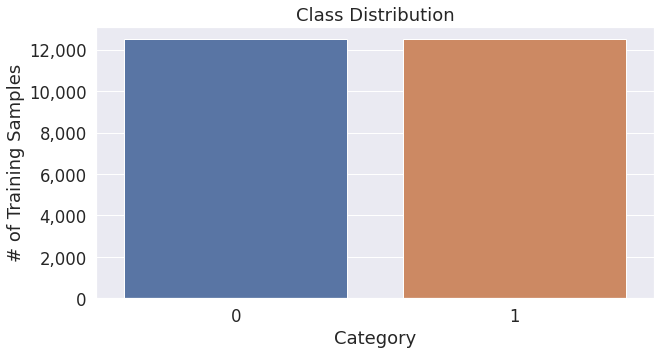

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the number of tokens of each length.
ax = sns.countplot(train_labels)

# Add labels
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('# of Training Samples')

# Add thousands separators to the y-axis labels.
import matplotlib as mpl
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

# S4. Smart Batching

In this section, we will prepare our training set into these smart batches.

We'll do it in Notebook style, with a mix of code and text cells so we can inspect and discuss things as we go. 

Note, though, that I've also defined a `make_smart_batches` function towards the end which performs all of these steps. We'll use that function to prepare the test set, and you could use that function in your own applications for both the training and test sets.

## 4.1. Load Tokenizer

We'll use the uncased version of BERT-base. 

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


## 4.2. Tokenize Without Padding

**Peak GPU Memory Use**

Even when applying smart batching, we may still want to truncate our inputs to a certain maximum length. BERT requires a lot of GPU memory, and it's quite possible for the GPU to not be able to process a batch with too many samples in it and / or too long of sequences. 

Smart batching means most of our batches will naturally have shorter sequence lengths and not require too much memory. However, all it takes is one batch  that's too long to fit on the GPU, and our training will fail! 

In other words, we still have to be concerned with our "peak" memory usage, and it still likely makes sense to truncate to something lower than 512, even with smart batching.

In [ ]:
max_len = 400

**Tokenize, but don't pad**

We're going to start by tokenizing all of the samples and mapping the tokens to their IDs. 

We're also going to truncate the sequences to our chosen `max_len`, and we're going to add the special tokens.

But we are **not padding** yet! We don't know what lengths to pad the sequences too until after we've grouped them into batches.



In [ ]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_text)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_text), num_desired_updates=10)

# For each training example...
for text in train_text:
    
    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,           # Movie review text
                                 add_special_tokens=True, # Do add specials.
                                 max_length=max_len,  # Do truncate to `max_len`
                                 truncation=True,     # Do truncate!
                                 padding=False)       # Don't pad!
                                 
    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)
    
print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 25,000 training samples...
  Tokenized 0 samples.
  Tokenized 2,000 samples.
  Tokenized 4,000 samples.
  Tokenized 6,000 samples.
  Tokenized 8,000 samples.
  Tokenized 10,000 samples.
  Tokenized 12,000 samples.
  Tokenized 14,000 samples.
  Tokenized 16,000 samples.
  Tokenized 18,000 samples.
  Tokenized 20,000 samples.
  Tokenized 22,000 samples.
  Tokenized 24,000 samples.
DONE.
    25,000 samples


## 4.3. Sort by length

Before we sort the samples by length, let's look at the lengths of the samples in their original, unsorted order. 

The below plot simply confirms that the sample lengths do vary significantly, and that they are unsorted.

In [ ]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

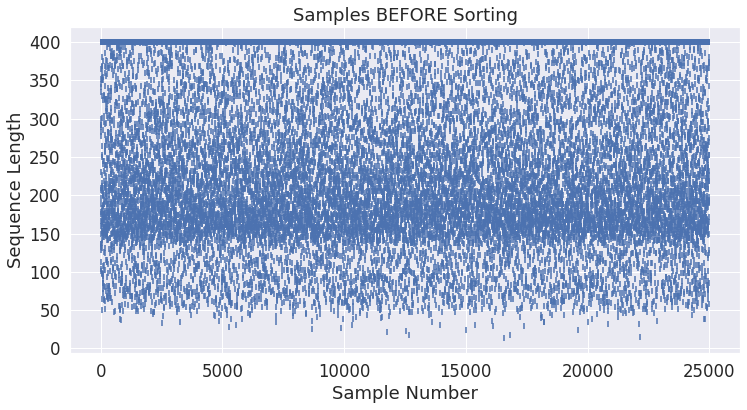

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

Now we'll sort the examples by length so that we can create batches with equal (or at least similar) lengths.

**NOTE:** One departure I've made from Michael's code is in how I sort. Michael sorted the samples by *strength length*, whereas my code is sorting them
by their *number of tokens*. The two approaches are very similar of course, but I did confirm that they result in slightly different ordering of the samples.

In [ ]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

`train_samples` is now a list of tuples of (input_ids, label):

In [ ]:
train_samples[0]

([101, 2023, 3185, 2003, 6659, 2021, 2009, 2038, 2070, 2204, 3896, 1012, 102],
 0)

In [ ]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 13
Longest sample: 400


Let's generate the same plot again, now that the samples are sorted by length.

In [ ]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

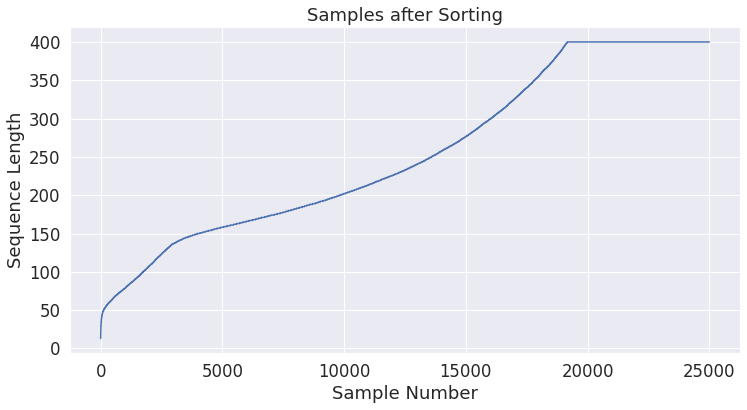

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

## 4.4. Random Batch Selection

Choose our batch size.

In [ ]:
batch_size = 16

Now we're ready to select our batches.

The strategy used here comes from Michaël Benesty's code, in his `build_batches` function. 

Rather than dividing the batches up in order, we will still add a degree of
**randomness** to our selection.

Here's the process:
1. Pick a random starting point in the (sorted!) list of samples.
2. Grab a contiguous batch of samples starting from that point.
3. Delete those samples from the list, and repeat until all of the samples have been grabbed.

This will result in some **fragmentation** of the list, which means it won't be quite as efficient as if we just sliced up the batches in sorted order.

The benefit is that our path through the training set can still have a degree of randomness. Also, given the distribution of lengths that we saw in the previous section (lots of samples with similar lengths), I bet the fragmentation problem is pretty minor!



In [ ]:
import random

# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...    
while len(train_samples) > 0:
    
    # Report progress.
    if ((len(batch_ordered_sentences) % 500) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until 
    # we get to the last batch, which may be smaller. 
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of 
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 500 batches.
  Selected 1,000 batches.
  Selected 1,500 batches.

  DONE - 1,563 batches.


## 4.5. Add Padding

We've created our batches, but many of them will contain sequences of different lengths. In order to leverage the GPUs parallel processing of batches, all of the sequences *within a batch* need to be the same length.

This means we need to do some padding!

We'll also create our **attention masks** here, and cast everything to **PyTorch tensors** in preparation for our fine-tuning step.

In [ ]:
import torch

py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []
    
    # First, find the longest sample in the batch. 
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:
        
        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


Now that our data is ready, we can calculate the total number of tokens in the training data after using smart batching.

In [ ]:
# Get the new list of lengths after sorting.
padded_lengths = []

# For each batch...
for batch in py_inputs:
    
    # For each sample...
    for s in batch:
    
        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_text) * max_len

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 10,000,000
  Smart Batching: 6,381,424  (36.2% less)


We'll see at the end that this reduction in token count corresponds well to the reduction in training time!

## 4.6. Old Approach - Fixed Padding

To see how BERT does on the benchmark *without* smart batching, you can run the following cell instead of sections 4.2. - 4.5.

In [ ]:
use_fixed_padding = False

if use_fixed_padding:

    # Specify batch_size and truncation length.    
    batch_size = 16
    max_len = 400   

    # Tokenize all training examples
    print('Tokenizing {:,} training samples...'.format(len(train_text)))

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    batches_input_ids = []
    batches_attention_masks = []
    batches_labels = []

    update_interval = batch_size * 150 

    # For every sentence...
    for i in range(0, len(train_text), batch_size):

        # Report progress.
        if ((i % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(i))

        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.batch_encode_plus(
                            train_text[i:i+batch_size], # Batch of sentences to encode.
                            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                            max_length = 400,           # Pad & truncate all sentences.
                            padding = 'max_length',     # Pad all to the `max_length` parameter.
                            truncation = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        batches_input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        batches_attention_masks.append(encoded_dict['attention_mask'])

        # Add the labels for the batch
        batches_labels.append(torch.tensor(train_labels[i:i+batch_size]))
    
    # Rename the final variable to match the rest of the code in this Notebook.
    py_inputs = batches_input_ids
    py_attn_masks = batches_attention_masks
    py_labels = batches_labels

# S5. Fine-Tune BERT

## 5.1. Load Pre-Trained Model

We'll use BERT-base-uncased for this example. 

`transformers` defines these `Auto` classes which will automatically select the correct class for the specifc pre-trained model that you specified.



In [ ]:
from transformers import AutoConfig

# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path='bert-base-uncased',
                                    num_labels=2)

print('Config type:', str(type(config)), '\n')



Config type: <class 'transformers.configuration_bert.BertConfig'> 



In [ ]:
from transformers import AutoModelForSequenceClassification

# Load the pre-trained model for classification, passing in the `config` from
# above.
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path='bert-base-uncased',
    config=config)

print('\nModel type:', str(type(model)))


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model type: <class 'transformers.modeling_bert.BertForSequenceClassification'>


Connect to the GPU and load our model onto it.

It's worth taking note of which GPU you're given. The Tesla P100 is much faster, for example, than the Tesla K80.

In [ ]:
import torch

print('\nLoading model to GPU...')

device = torch.device('cuda')

print('  GPU:', torch.cuda.get_device_name(0))

desc = model.to(device)

print('    DONE.')


Loading model to GPU...
  GPU: Tesla K80
    DONE.


## 5.2. Optimizer & Learning Rate Scheduler

Set up our optimizer and learning rate scheduler for training.

In [ ]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 5.3. Training Loop

In previous examples I've made use of the PyTorch Dataset and DataLoader classes, but because of the smart batching I'm not using them in this Notebook.

*Note: If you have modified this Notebook to run for more than one epoch, you'll need the `make_smart_batches` function defined in section 6.1.*


We're ready to kick off the training!

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 321

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    
    # At the start of each epoch (except for the first) we need to re-randomize
    # our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function (from 6.1.) to re-shuffle the 
        # dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_text, train_labels, batch_size)
    
    print('Training on {:,} batches...'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training on 1,563 batches...
  Batch     200  of    1,563.    Elapsed: 0:04:33.  Remaining: 0:30:58
  Batch     400  of    1,563.    Elapsed: 0:08:52.  Remaining: 0:25:47
  Batch     600  of    1,563.    Elapsed: 0:13:15.  Remaining: 0:21:16
  Batch     800  of    1,563.    Elapsed: 0:17:47.  Remaining: 0:16:58
  Batch   1,000  of    1,563.    Elapsed: 0:22:22.  Remaining: 0:12:36
  Batch   1,200  of    1,563.    Elapsed: 0:27:04.  Remaining: 0:08:11
  Batch   1,400  of    1,563.    Elapsed: 0:31:19.  Remaining: 0:03:39

  Average training loss: 0.25
  Training epcoh took: 0:35:06

Training complete!
Total training took 0:35:06 (h:mm:ss)


# S6. Evaluate on Test Set

### 6.1. `make_smart_batches`

This function combines all of the steps from the "Smart Batching" section into a single (re-usable) function. You can use this in your own Notebook for applying smart batching to both your training and test sets.

In [ ]:
def make_smart_batches(text_samples, labels, batch_size):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_len,      # Do Truncate!
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


## 6.2. Load Test Dataset & Smart Batch

Load the test dataset. This file has more columns, and contains rows for different languages (we'll only select the French test samples).

In [ ]:
# Use our new function to completely prepare our dataset.
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(test_text, test_labels, batch_size)

Creating Smart Batches from 25,000 examples with batch size 16...

Tokenizing 25,000 samples...
  Tokenized 0 samples.
  Tokenized 2,000 samples.
  Tokenized 4,000 samples.
  Tokenized 6,000 samples.
  Tokenized 8,000 samples.
  Tokenized 10,000 samples.
  Tokenized 12,000 samples.
  Tokenized 14,000 samples.
  Tokenized 16,000 samples.
  Tokenized 18,000 samples.
  Tokenized 20,000 samples.
  Tokenized 22,000 samples.
  Tokenized 24,000 samples.
DONE.
    25,000 samples

    25,000 samples after sorting

Creating batches of size 16...

  DONE - Selected 1,563 batches.

Padding out sequences within each batch...
  DONE.


## 6.3. Evaluate


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_labels)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure elapsed time.
t0 = time.time()

# Put model in evaluation mode
model.eval()

# For each batch of training data...
for step in range(0, len(py_inputs)):

    # Progress update every 100 batches.
    if step % update_interval == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Calculate the time remaining based on our progress.
        steps_per_sec = (time.time() - t0) / step
        remaining_sec = steps_per_sec * (len(py_inputs) - step)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

    # Copy the batch to the GPU.
    b_input_ids = py_inputs[step].to(device)
    b_input_mask = py_attn_masks[step].to(device)
    b_labels = py_labels[step].to(device)
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 25,000 test sentences...
  Batch     200  of    1,563.    Elapsed: 0:01:32.  Remaining: 0:10:27
  Batch     400  of    1,563.    Elapsed: 0:03:03.  Remaining: 0:08:53
  Batch     600  of    1,563.    Elapsed: 0:04:35.  Remaining: 0:07:21
  Batch     800  of    1,563.    Elapsed: 0:06:05.  Remaining: 0:05:48
  Batch   1,000  of    1,563.    Elapsed: 0:07:37.  Remaining: 0:04:17
  Batch   1,200  of    1,563.    Elapsed: 0:09:08.  Remaining: 0:02:46
  Batch   1,400  of    1,563.    Elapsed: 0:10:44.  Remaining: 0:01:15
    DONE.


Now we can calculate the test set accuracy!

In [ ]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Choose the label with the highest score as our prediction.
preds = np.argmax(predictions, axis=1).flatten()

# Calculate simple flat accuracy -- number correct over total number.
accuracy = (preds == true_labels).mean()

print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.935


Here are my results from running a single training epoch on a Tesla K80, comparing fixed-padding to smart batching.

| Padding Strategy |   Model   | Batch Size | Max Len | Test Accur. |    GPU    | Training Time per Epoch (mm:ss) |
|:----------------:|:---------:|:----------:|:-------:|:-----------:|:---------:|:-------------------------------:|
|  Smart Batching  | BERT-base |     16     |   400   |    0.935    | Tesla K80 |             0:35:06             |
|   Fixed Padding  | BERT-base |     16     |   400   |     0.93    | Tesla K80 |             0:53:14             |

The fixed padding approach took 51.7% longer to train the model than Smart Batching!



# Appendix

### Smart Batching with `batch_encode_plus` and `DataLoader`

This section discusses how "smart batching" might be implemented in a more formal way with the PyTorch `DataLoader` class and using the features currently available in huggingface `transformers`.

In `transformers`, the `batch_encode_plus` function does have support for "Dynamic Padding"--it can automatically pad all of the samples in a batch out to match the longest sequence length in the batch.

Check out the explanation given in this Warning in the source code, in [tokenization_utils_base.py](https://github.com/huggingface/transformers/blob/master/src/transformers/tokenization_utils_base.py#L1458):

> "The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert)."

So I think the call would look like this:


In [ ]:
# Encode a batch of sentences with dynamic padding.
encoded_dict = tokenizer.batch_encode_plus(
                    train_text[i:i+batch_size], # Batch of sentences to encode.
                    add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                    padding = 'longest',        # Pad to longest in batch.
                    truncation = True,          # Truncate sentences to `max_length`.
                    max_length = 400,           
                    return_attention_mask = True, # Construct attn. masks.
                    return_tensors = 'pt',        # Return pytorch tensors.
            )


However, if you do this, you need wait to actually encode your text until the random training samples for the batch have been selected! i.e., you can't pre-tokenize all of your sentences the way we have been.

I believe the "correct" approach would be to implement a custom DataLoader class which:
1. Stores the original training sample strings, *sorted by string length*.
2. Selects a contiguous batch of samples starting at a random point in the list. 
3. Calls `batch_encode_plus` to encode the samples with dynamic padding, then returns the training batch.



### Impact of `[PAD]` tokens on accuracy

The difference in accuracy (0.93 for fixed-padding and 0.935 for smart batching) is interesting--I believe Michael had the same observation. It makes me curious to look at the attention mask implementation more--perhaps the `[PAD]` tokens are still having some small influence on the results. 

Maybe the Attention scores are calculated for all tokens, including the `[PAD]` tokens, and then the scores are multiplied against the mask, to zero out the scores for the `[PAD]` tokens? Because the SoftMax makes all of the attention scores sum to 1.0, that would mean the presence of `[PAD]` tokens would cause the scores for the real words to be lower...